<table border="0">
    <tr>
        <td>
            <img src="https://ictd2016.files.wordpress.com/2016/04/microsoft-research-logo-copy.jpg" style="width 30px;" />
             </td>
        <td>
            <img src="https://www.microsoft.com/en-us/research/wp-content/uploads/2016/12/MSR-ALICE-HeaderGraphic-1920x720_1-800x550.jpg" style="width 100px;"/></td>
        </tr>
</table>

# Treatment Featurization Examples 

Many EconML estimators model treatment effects as linear with respect to the treatment. However, there are times when one may want to impose a particular form of non-linearity in the treatment effect. For example, one may believe that the outcome is linear with respect to treatment squared, or more generally, linear with respect to some featurization of the treatment. We enable users to pass such a featurization via the `treatment_featurizer` arg. This notebook walks through some examples where treatment featurization may be useful.  

The EconmL SDK supports treatment featurization for many backdoor and IV estimators, including:

* Backdoor
    * LinearDML
    * SparseLinearDML
    * KernelDML
    * CausalForestDML
    * DMLOrthoForest
    * NonParamDML
    * DML
    
* IV
    * OrthoIV
    * DMLIV
    * NonParamDMLIV
    * DRIV
    * LinearDRIV
    * SparseLinearDRIV
    * ForestDRIV
    

**Notebook contents:**
1. Treatment Featurization for a backdoor estimator.
2. Treatment Featurization for an IV estimator.

# Imports 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# EconML imports
from econml.dml import LinearDML
from econml.iv.dml import OrthoIV

# Generic ML imports
from sklearn.preprocessing import PolynomialFeatures # featurizer class
from sklearn.ensemble import RandomForestRegressor

# Treatment Featurization for a backdoor estimator 

## Simulate data 

We generate data where the outcome depends on the square of the treatment.

In [2]:
n = 2000
d_w = 5
W = np.random.normal(size = (n, d_w), scale = 5)
T = np.random.uniform(low = 0, high = 10, size = (n, 1)) + 0.5*W[:, [0]]
epsilon = np.random.normal(size = (n, 1))*20
Y = 0.5*T**2 + W[:, [1]] + epsilon

test_T = np.arange(0, 10, step = 0.1).reshape(-1, 1)

featurizer = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

## Run estimation 

Here we run two estimators, one with treatment featurization and one without treatment featurization for comparison

In [3]:
est = LinearDML(treatment_featurizer = featurizer)
est.fit(Y=Y, T=T, W=W)

bad_est = LinearDML()
bad_est.fit(Y=Y, T=T, W=W)

est.summary()

Coefficient Results:  X is None, please call intercept_inference to learn the constant!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept|T0,-0.478,0.301,-1.591,0.112,-1.068,0.111
cate_intercept|T0^2,0.526,0.025,20.845,0.0,0.476,0.575


## Plot effects 

Text(0.5, 1.0, 'Treatment Effect vs Treatment value')

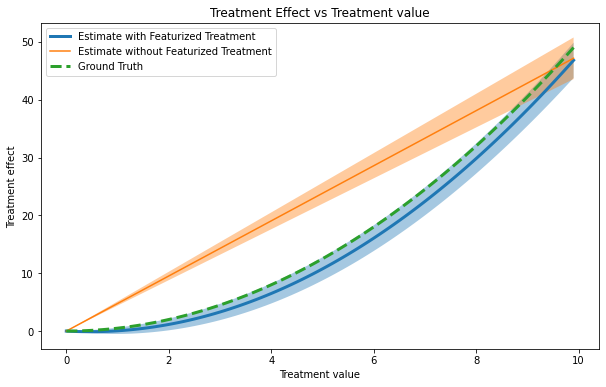

In [4]:
plt.figure(figsize=(10, 6))

# Plot point estimates
plt.plot(
    test_T,
    est.effect(T0 = 0, T1=test_T),
    label = 'Estimate with Featurized Treatment',
    linewidth=3
)

plt.plot(
    test_T,
    bad_est.effect(T0 = 0, T1=test_T),
    label = 'Estimate without Featurized Treatment'
)

plt.plot(
    test_T,
    0.5*test_T**2,
    linestyle='--',
    linewidth=3,
    label='Ground Truth',
)

# Plot confidence intervals
lb, ub = est.effect_interval(T0 = np.zeros(shape=(100, 1)), T1=test_T)

plt.fill_between(
    test_T.squeeze(),
    lb.squeeze(),
    ub.squeeze(),
    alpha = 0.4, 
)

lb, ub = bad_est.effect_interval(T0 = np.zeros(shape=(100, 1)), T1=test_T)

plt.fill_between(
    test_T.squeeze(),
    lb.squeeze(),
    ub.squeeze(),
    alpha = 0.4
)

plt.legend()
plt.xlabel('Treatment value')
plt.ylabel('Treatment effect')
plt.title('Treatment Effect vs Treatment value')

# Treatment featurization in IV methods 

## Simulate data 

In [5]:
n = 2000
d_w = 5
W = np.random.normal(size = (n, d_w), scale = 5)
Z = np.random.normal(loc = 3, scale = 5, size = (n, 1))
T = np.random.uniform(low = 0, high = 10, size = (n, 1)) + 0.5*W[:, [0]] + Z
epsilon = np.random.normal(size = (n, 1)) * 20
Y = 0.5*T**2 + W[:, [1]] + epsilon

test_T = np.arange(0, 10, step = 0.1).reshape(-1, 1)

featurizer = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

## Run estimation 

Here we run two estimators, one with treatment featurization and one without treatment featurization for comparison

In [6]:
# when the dimension of featurized treatment is larger than the original treatment, it may be helpful to pass projection=True along with a flexible model_t_xwz
est = OrthoIV(
    model_t_xwz=RandomForestRegressor(), 
    projection=True, 
    treatment_featurizer = featurizer
)
est.fit(Y=Y, T=T, W=W, Z=Z)

bad_est = OrthoIV()
bad_est.fit(Y=Y, T=T, W=W, Z=Z)

est.summary()

Coefficient Results:  X is None, please call intercept_inference to learn the constant!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept|T0,-0.066,0.179,-0.37,0.712,-0.418,0.285
cate_intercept|T0^2,0.503,0.01,48.775,0.0,0.483,0.523


Text(0.5, 1.0, 'Treatment Effect vs Treatment value')

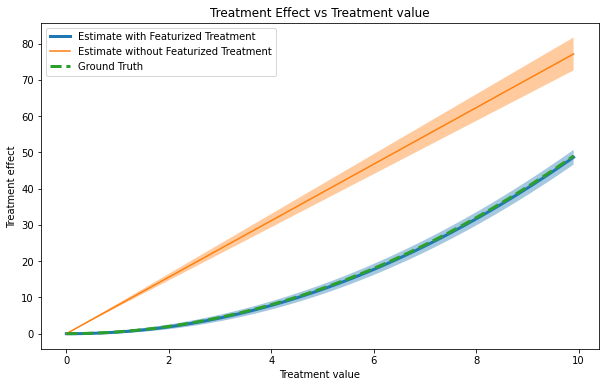

In [7]:
plt.figure(figsize=(10, 6))

# Plot point estimates
plt.plot(
    test_T,
    est.effect(T0 = 0, T1=test_T),
    label = 'Estimate with Featurized Treatment',
    linewidth=3
)

plt.plot(
    test_T,
    bad_est.effect(T0 = 0, T1=test_T),
    label = 'Estimate without Featurized Treatment'
)

plt.plot(
    test_T,
    0.5*test_T**2,
    linestyle='--',
    linewidth=3,
    label='Ground Truth',
)

# Plot confidence intervals
lb, ub = est.effect_interval(T0 = np.zeros(shape=(100, 1)), T1=test_T)

plt.fill_between(
    test_T.squeeze(),
    lb.squeeze(),
    ub.squeeze(),
    alpha = 0.4, 
)

lb, ub = bad_est.effect_interval(T0 = np.zeros(shape=(100, 1)), T1=test_T)

plt.fill_between(
    test_T.squeeze(),
    lb.squeeze(),
    ub.squeeze(),
    alpha = 0.4
)

plt.legend()
plt.xlabel('Treatment value')
plt.ylabel('Treatment effect')
plt.title('Treatment Effect vs Treatment value')